# **In-Class Assignment: Text Summarization: Extraction**

## *IS 5150*
## Name: Cailean

In the lecture we discussed that there are two main forms of text summarization:


1.   Extraction-based summarization
2.   Abstraction-based summarization

In this in-class assignment, we will run through an example of an extraction-based summarization technique, as abstraction-based methods require much more data and compute power to produce successfully. We will work towards producing a simple summary of a video game description for *The Elder Scrolls V: Skyrim*. I provide the description below; but first we'll import all our dependencies.



In [ ]:
import re
import gensim
from gensim.summarization import summarize

import nltk
nltk.download('punkt')
nltk.download('stopwords')
import numpy as np

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd

import scipy
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import networkx

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
DOCUMENT = """
The Elder Scrolls V: Skyrim is an action role-playing video game developed by Bethesda Game Studios
and published by Bethesda Softworks. It is the fifth main installment in The Elder Scrolls series,
following The Elder Scrolls IV: Oblivion.
The game's main story revolves around the player character's quest to defeat Alduin the World-Eater,
a dragon who is prophesied to destroy the world. The game is set 200 years after the events of Oblivion
and takes place in the fictional province of Skyrim. Over the course of the game, the player completes
quests and develops the character by improving skills. The game continues the open-world tradition of
its predecessors by allowing the player to travel anywhere in the game world at any time, and to ignore
or postpone the main storyline indefinitely.
The team opted for a unique and more diverse open world than Oblivion's Imperial Province of Cyrodiil,
which game director and executive producer Todd Howard considered less interesting by comparison.
The game was released to critical acclaim, with reviewers particularly mentioning the character advancement
and setting, and is considered to be one of the greatest video games of all time.


The Elder Scrolls V: Skyrim is an action role-playing game, playable from either a first or
third-person perspective. The player may freely roam over the land of Skyrim which is an open world
environment consisting of wilderness expanses, dungeons, cities, towns, fortresses, and villages.
Players may navigate the game world more quickly by riding horses or by utilizing a fast-travel system
which allows them to warp to previously discovered locations. The game's main quest can be completed or
ignored at the player's preference after the first stage of the quest is finished. However, some quests
rely on the main storyline being at least partially completed. Non-player characters (NPCs) populate the
world and can be interacted with in a number of ways: the player may engage them in conversation,
marry an eligible NPC, kill them or engage in a nonlethal "brawl". The player may
choose to join factions which are organized groups of NPCs — for example, the Dark Brotherhood, a band
of assassins. Each of the factions has an associated quest path to progress through. Each city and town
in the game world has jobs that the player can engage in, such as farming.

Players have the option to develop their character. At the beginning of the game, players create
their character by selecting their sex and choosing between one of several races including humans,
orcs, elves, and anthropomorphic cat or lizard-like creatures and then customizing their character's
appearance. Over the course of the game, players improve their character's skills which are numerical
representations of their ability in certain areas. There are eighteen skills divided evenly among the
three schools of combat, magic, and stealth. When players have trained skills enough to meet the
required experience, their character levels up. Health is depleted primarily when the player
takes damage and the loss of all health results in death. Magicka is depleted by the use of spells,
certain poisons and by being struck by lightning-based attacks. Stamina determines the player's
effectiveness in combat and is depleted by sprinting, performing heavy "power attacks"
and being struck by frost-based attacks. Skyrim is the first entry in The Elder Scrolls to
include dragons in the game's wilderness. Like other creatures, dragons are generated randomly in
the world and will engage in combat with NPCs, creatures and the player. Some dragons may attack
cities and towns when in their proximity. The player character can absorb the souls of dragons
in order to use powerful spells called "dragon shouts" or "Thu'um". A regeneration
period limits the player's use of shouts in gameplay.

Skyrim is set around 200 years after the events of The Elder Scrolls IV: Oblivion, although it is
not a direct sequel. The game takes place in Skyrim, a province of the Empire on the continent of
Tamriel, amid a civil war between two factions: the Stormcloaks, led by Ulfric Stormcloak, and the
Imperial Legion, led by General Tullius. The player character is a Dragonborn, a mortal born with
the soul and power of a dragon. Alduin, a large black dragon who returns to the land after being
lost in time, serves as the game's primary antagonist. Alduin is the first dragon created by Akatosh,
one of the series' gods, and is prophesied to destroy and consume the world.
"""

## **1) Basic Text Preprocessing**

This text is already really clean, so our preprocessing will be pretty minimal. Let's go ahead and just remove extra lines and spaces using some basic regex string replacements.

In [ ]:
DOCUMENT = re.sub(r'\n|\r', ' ', DOCUMENT)
DOCUMENT = re.sub(r' +', ' ', DOCUMENT)
DOCUMENT = DOCUMENT.strip()

## **2) Gensim Built-In Summarizer**

Gensim comes with its own pretrained summarizer, so we can check that out as a comparison before we go ahead and develop our own:

In [ ]:
# print summary that limits the length of summary by proportion of the document
print(summarize(DOCUMENT, ratio =0.2, split = False))

The game's main story revolves around the player character's quest to defeat Alduin the World-Eater, a dragon who is prophesied to destroy the world.
Over the course of the game, the player completes quests and develops the character by improving skills.
The game continues the open-world tradition of its predecessors by allowing the player to travel anywhere in the game world at any time, and to ignore or postpone the main storyline indefinitely.
The player may freely roam over the land of Skyrim which is an open world environment consisting of wilderness expanses, dungeons, cities, towns, fortresses, and villages.
Each city and town in the game world has jobs that the player can engage in, such as farming.
Over the course of the game, players improve their character's skills which are numerical representations of their ability in certain areas.
Like other creatures, dragons are generated randomly in the world and will engage in combat with NPCs, creatures and the player.


In [ ]:
# print summary that limits length based on word count

print(summarize(DOCUMENT, word_count = 75, split = False))

The game's main story revolves around the player character's quest to defeat Alduin the World-Eater, a dragon who is prophesied to destroy the world.
Over the course of the game, the player completes quests and develops the character by improving skills.
The player may freely roam over the land of Skyrim which is an open world environment consisting of wilderness expanses, dungeons, cities, towns, fortresses, and villages.


**The first summary gives us about six sentences and the second gives us about three. What is the main difference between extraction and abstraction-based summarization techniques? In your opinion, does the extraction based summary do a good job in summarizing the point of the game?**

Extraction takes from the text, abstraction triest o distill the text down to the gist, but creates new sentences (NLG). so it does a decent job of providing information about characters and some aspects of game play.

## **3) Utilizing Algorithms to Develop a Text Summarizer**

We will now construct our own extraction-based summarizer using two different algorithms:



1.   *Latent Semantic Indexing*
2.   *TextRank*

We begin this process by performing a bit of additional text preprocessing on our corpus:



In [ ]:
# sentence tokenize our document
sentences = nltk.sent_tokenize(DOCUMENT)
# find number of sentences
len(sentences)

35

In [ ]:
stop_words = nltk.corpus.stopwords.words('english')                             # bring in nltk stopword list


def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)                             # lower case and remove special characters\whitespaces
    doc = doc.lower()
    doc = doc.strip()
    tokens = nltk.word_tokenize(doc)                                             # tokenize document
    filtered_tokens = [token for token in tokens if token not in stop_words]     # filter stopwords out of document
    doc = ' '.join(filtered_tokens)                                              # re-create document from filtered tokens
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [ ]:
norm_sentences = normalize_corpus(sentences)
norm_sentences[:3]

array(['elder scrolls v skyrim action roleplaying video game developed bethesda game studios published bethesda softworks',
       'fifth main installment elder scrolls series following elder scrolls iv oblivion',
       'games main story revolves around player characters quest defeat alduin worldeater dragon prophesied destroy world'],
      dtype='<U183')

> #### **A) Feature Engineering**

We will use basic TF-IDF features weights to vectorize our corpus, using the `TdidfVectorizer` from `sklearn`.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
dt_matrix = tv.fit_transform(norm_sentences)
dt_matrix = dt_matrix.toarray()

vocab = tv.get_feature_names_out()
td_matrix = dt_matrix.T
print(td_matrix.shape)
pd.DataFrame(np.round(td_matrix, 2), index=vocab).head(10)

(270, 35)


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
ability,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
absorb,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.31,0.0,0.00,0.0,0.0,0.00,0.00
acclaim,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.28,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
action,0.25,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.32,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
advancement,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.28,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
akatosh,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.33
alduin,0.00,0.0,0.25,0.0,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.26,0.27
allowing,0.00,0.0,0.00,0.0,0.0,0.27,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
allows,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
although,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.33,0.0,0.0,0.00,0.00


**Why are there 35 columns in this term-document matrix?**

There are 35 sentences represented by the columns in matrix. each is a sentence/document vector.

> #### **B) Latent Semantic Indexing (LSI)**

Remember LSI from topic modeling? Well it can similarly be implemented for the purpose of document summarization, but instead of trying to find the top words within each topic, we are working at the sentence level to find the top (most salient) sentences within a corpus (in this case a collection of related sentences, each sentence is treated as a document).

The process is very similar to topic modeling in using SVD to decompose the term-document matrix into several sub matrices, but in this case we will be using sentence-level tokens, tf-idf feature reprensetation, and producing a 'salience' score for each sentence by taking the square root of the dot product of the squared topic-topic matrix and the topic-document matrices -- produced via SVD.



In [ ]:
# set parameters of low_rank_svd, return decomposed matrices
def low_rank_svd(matrix, singular_count = 2,):
  u, s, vt = svds(matrix, k = singular_count)
  return u, s, vt

In [ ]:
# set number of sentences we want summary to contain
num_sentences = 6
num_topics = 3
# num_topics = 3, since summary was taken from 3 diff sections of Wikipedia

u, s, vt = low_rank_svd(td_matrix, singular_count = num_topics)
print(u.shape, s.shape, vt.shape)
term_topic_mat, singular_values, topic_document_mat = u, s, vt


# apply svd to our term-document matrix
# display matrix shapes

(270, 3) (3,) (3, 35)


In [ ]:
# set minimum value, set values below threshold to 0
sv_threshold = 0.5
min_sigma_value = max(singular_values) * sv_threshold
singular_values[singular_values < min_sigma_value] = 0

In [ ]:
salience_scores = np.sqrt(np.dot(np.square(singular_values),                                      # calculate salience scores of sentences
                                 np.square(topic_document_mat)))
salience_scores

array([0.53291263, 0.61639562, 0.60427539, 0.52307109, 0.50141128,
       0.32352969, 0.1506046 , 0.25383436, 0.60567083, 0.35902104,
       0.22562997, 0.34608934, 0.15781555, 0.40522541, 0.24505982,
       0.19874104, 0.39317895, 0.45392878, 0.31638528, 0.47353378,
       0.18348908, 0.45731421, 0.13929749, 0.38932101, 0.36829067,
       0.57822992, 0.40853736, 0.26260062, 0.38904585, 0.32776714,
       0.67662776, 0.21866561, 0.34687796, 0.3234621 , 0.46107093])

In [ ]:
top_sentence_indices = (-salience_scores).argsort()[:num_sentences]                                # take 6 most salient sentences and sort them (in order of sequential appearance)
top_sentence_indices.sort()

In [ ]:
print('\n'.join(np.array(sentences)[top_sentence_indices]))

The Elder Scrolls V: Skyrim is an action role-playing video game developed by Bethesda Game Studios and published by Bethesda Softworks.
It is the fifth main installment in The Elder Scrolls series, following The Elder Scrolls IV: Oblivion.
The game's main story revolves around the player character's quest to defeat Alduin the World-Eater, a dragon who is prophesied to destroy the world.
The Elder Scrolls V: Skyrim is an action role-playing game, playable from either a first or third-person perspective.
Skyrim is the first entry in The Elder Scrolls to include dragons in the game's wilderness.
Skyrim is set around 200 years after the events of The Elder Scrolls IV: Oblivion, although it is not a direct sequel.


**Compare our LSI generated summary to the Gensim model. What are some differences between the two? Which would you say provides a better overview?**

the main difference is that the lSI summary appears to mainly have pulled content related to gameplay, where the gensim model pulled information related to characters, plot and gamepaly.

> #### **C) TextRank**

Now let's implement `TextRank`, which is a graph-based method of ranking sentences for extraction-based document summarization. We will use this method to generate a summary, and also generate a visualization of our graph network to see how are sentences connect to one another!

We will begin by creating our similarity matrix by performing a matrix multiplication of the document-term matrix against the transposed document-term matrix.

In [ ]:
similarity_matrix = np.matmul(dt_matrix, dt_matrix.T)                                 # multiply the document-term matrix against the transposed document matrix
print(similarity_matrix.shape)                                                        # print the shape
np.round(similarity_matrix, 3)                                                        # round the decimal places to

(35, 35)


array([[1.   , 0.182, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.182, 1.   , 0.05 , ..., 0.   , 0.   , 0.084],
       [0.   , 0.05 , 1.   , ..., 0.101, 0.165, 0.319],
       ...,
       [0.   , 0.   , 0.101, ..., 1.   , 0.066, 0.069],
       [0.   , 0.   , 0.165, ..., 0.066, 1.   , 0.123],
       [0.   , 0.084, 0.319, ..., 0.069, 0.123, 1.   ]])

In [ ]:
similarity_graph = networkx.from_numpy_array(similarity_matrix)                       # build the similarity graph
similarity_graph

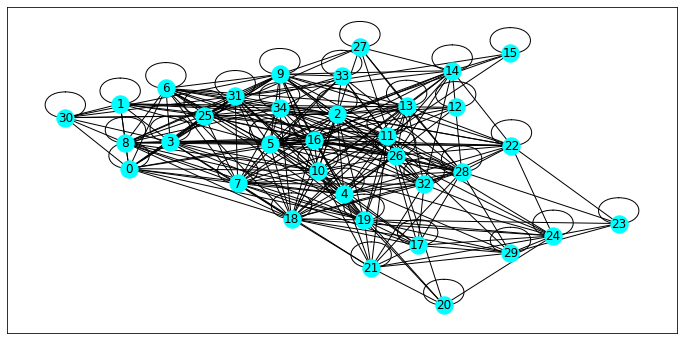

In [ ]:
%matplotlib inline

plt.figure(figsize=(12, 6))
networkx.draw_networkx(similarity_graph, node_color='aqua')                         # view the similarity graph

**What do the blue circles represent? What about the lines?**

They represent the sentences in the corpus. The lines represent sentences being connected to one another.

**Which sentences might you anticipate showing up in our top 10 most important sentences, and why?**

sentence 10, 26, or 5 are probably important sentences. they are connected to lots of the other sentences, whereas, sentences on the outsides (like 20) aren't as connected to others, and thus are probably not as important.

In [ ]:
scores = networkx.pagerank(similarity_graph)                                              # extract sentence scores from graph
ranked_sentences = sorted(((score, index) for index, score                                # rank the sentences by their score
                                            in scores.items()),
                          reverse=True)
ranked_sentences[:10]

[(0.037297049797214744, 2),
 (0.034908435475375886, 25),
 (0.03460086870923607, 4),
 (0.03240744530656925, 8),
 (0.03218748996523769, 28),
 (0.031836734268801445, 11),
 (0.031566658693076226, 26),
 (0.03150616293402057, 3),
 (0.031376143577383796, 5),
 (0.031123481531894214, 16)]

In [ ]:
top_sentence_indices = [ranked_sentences[index][1]                                      # create list of top sentence indices for set number of sentences
                        for index in range(num_sentences)]
top_sentence_indices.sort()                                                             # sort sentences

In [ ]:
print('\n'.join(np.array(sentences)[top_sentence_indices]))                             # join sentences in sequence, print

The game's main story revolves around the player character's quest to defeat Alduin the World-Eater, a dragon who is prophesied to destroy the world.
Over the course of the game, the player completes quests and develops the character by improving skills.
The Elder Scrolls V: Skyrim is an action role-playing game, playable from either a first or third-person perspective.
The game's main quest can be completed or ignored at the player's preference after the first stage of the quest is finished.
Skyrim is the first entry in The Elder Scrolls to include dragons in the game's wilderness.
The player character can absorb the souls of dragons in order to use powerful spells called "dragon shouts" or "Thu'um".


**How would you compare this summary to the one produced with LSA? Which do you feel provides a more meaningful summary and why?**

LSA seemed more choppy. Like a string of sentences thrown together. The text rank plot actually sounds like a summary. It explains what the characters are supposed to do, offers details about the game, and it even lets you know that you can play as a first or third person perspective.